In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, svm
from sklearn.preprocessing import StandardScaler
label_encoder = preprocessing.LabelEncoder()
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
try:
    train_df = pd.read_csv("Train.csv")
    test_data = pd.read_csv("Test.csv")
except:
    train_df = pd.read_csv("/kaggle/input/practice-hackathon/Train.csv")
    test_data = pd.read_csv("/kaggle/input/practice-hackathon/Test.csv")
    
train_df['A']= label_encoder.fit_transform(train_df['A'])
test_data['A']= label_encoder.fit_transform(test_data['A'])
Index=test_data['Index']
test_data.drop(['Index'],axis=1,inplace=True)

### I view correlations.

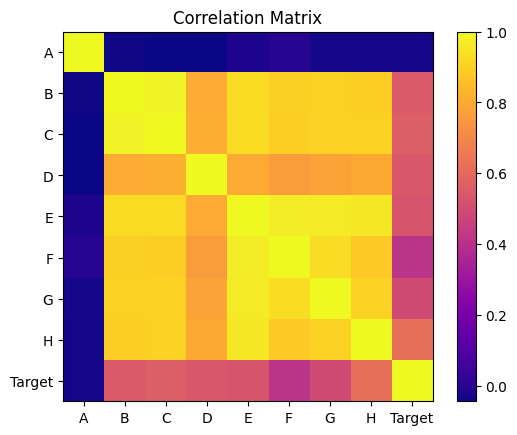

In [3]:
cols=list(train_df)

x_scaled = preprocessing.MinMaxScaler().fit_transform(train_df.values)

plt.imshow(train_df.corr().to_numpy(),cmap='plasma')
plt.xticks(np.arange(9), cols)
plt.yticks(np.arange(9), cols)

plt.title("Correlation Matrix")
plt.colorbar()
plt.show()

### I plot target distribution.

In [4]:
X = train_df.drop(['Target'], axis=1)
y = train_df['Target'].to_numpy()

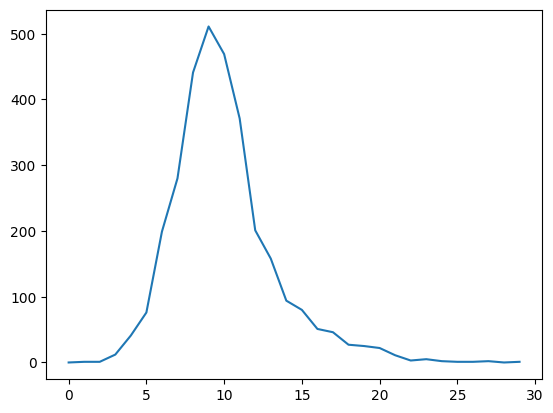

In [5]:
plt.plot(range(30), [list(y).count(i) for i in range(30)])

### X1 used to be scaled but I decided to remove scaling.

In [6]:
X1=X.copy()
#X1.iloc[:,1:8] = StandardScaler().fit(X1.iloc[:,1:8]).transform(X1.iloc[:,1:8])

### Split data over column A

In [7]:
X_0 = X1.iloc[:,1:][X.iloc[:,0]==0]
X_1 = X1.iloc[:,1:][X.iloc[:,0]==1]
X_2 = X1.iloc[:,1:][X.iloc[:,0]==2]

y_0 = y[X.iloc[:,0]==0]
y_1 = y[X.iloc[:,0]==1]
y_2 = y[X.iloc[:,0]==2]

### I plot target vs column i with f(i).<br>
Key hasn't done anything ever since X1 = X

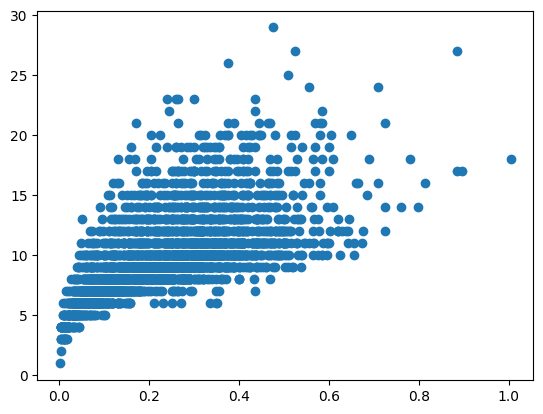

In [8]:
def f(i,key=0): # 0 to 7
    if key==1: plt.scatter(X1.iloc[:,i].to_list(),y)
    else: plt.scatter(X.iloc[:,i].to_list(),y)
    plt.show()
f(7,1)

### Plain Jane LinReg

In [9]:
model = LinearRegression()
model.fit(X1,y)

mean_squared_error(y,model.predict(X1))

4.9422267228773125

### Terrible. <br>I split into (training, testing) and pick the training data which generalizes best

In [10]:
n = 11
def set_best_model(n, X1, y, ridge=False):
    kf = KFold(n_splits=n, random_state=1, shuffle=True)
    min_score = float('inf')
    for i in range(n):
        itrain,itest = list(kf.split(X1))[i]
        try:
            X_ktrain = X1.iloc[itrain]
            #X_ktest = X1.iloc[itest]
            y_ktrain = y.iloc[itrain]
            #y_ktest = y.iloc[itest]
        except:
            X_ktrain = X1[itrain]
            y_ktrain = y[itrain]
        
        L = LinearRegression() if ridge==False else Ridge(alpha=1e-5)
        temp_model = L.fit(X_ktrain, y_ktrain)
        if ( min_candidate := mean_squared_error( temp_model.predict(X1), y) ) < min_score:
            model = temp_model
            min_score = min_candidate
    
    print( f"Model K{n}, a score of {min_score}" )
    return model

In [11]:
#model0 = set_best_model(10, X_0, y_0)
#model1 = set_best_model(16, X_1, y_1)
#model2 = set_best_model(13, X_2, y_2)

#for i in range(2,20): set_best_model(i, X_2, y_2)

### I change my mind and decide to fit to all data instead.<br>
### model0 to predict A=0 case, and so forth.

In [12]:
model0 = LinearRegression().fit(X_0, y_0)
print("Model 0, a score of", mean_squared_error(y_0, model0.predict(X_0)))
model1 = LinearRegression().fit(X_1, y_1)
print("Model 1, a score of", mean_squared_error(y_1, model1.predict(X_1)))
model2 = LinearRegression().fit(X_2, y_2)
print("Model 2, a score of", mean_squared_error(y_2, model2.predict(X_2)))

Model 0, a score of 6.097762170465555
Model 1, a score of 2.752347333256686
Model 2, a score of 5.080490501074644


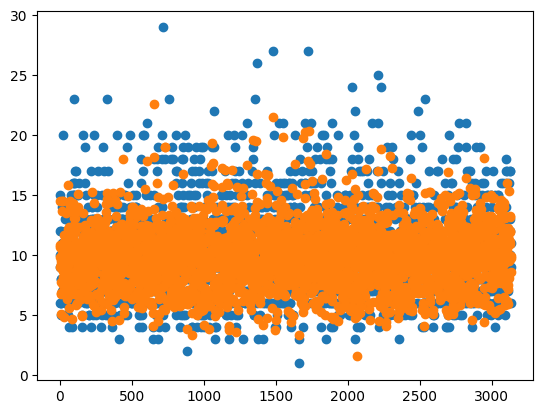

4.664972685586451

In [13]:
mother = []
X = X.to_numpy()
for i in range(len(X)):
    if (X[i,0]==0): mother.extend( model0.predict( X[i,1:].reshape(1,-1) ) )
    elif X[i,0]==1: mother.extend( model1.predict( X[i,1:].reshape(1,-1) ) )
    elif X[i,0]==2: mother.extend( model2.predict( X[i,1:].reshape(1,-1) ) )

plt.scatter(range(len(X)), y)
plt.scatter(range(len(X)), mother)
plt.show()
mean_squared_error(y, mother)

### 4.66, an improvement over 4.9
<br> I see its time for feature engineering.

# Poly Features

In [14]:
def find_best_pow(col, a, b, show=False):
    Y = y.copy().reshape(-1,1)
    x = X1.iloc[:,col].to_numpy().reshape(-1,1)
    
    m1=m2=-1
    min_error = float('inf')
    for p1 in a:
        for p2 in b:
            X = np.hstack((x**p1,x**p2))
            L = LinearRegression().fit(X,Y)
            if (e:=mean_squared_error(Y, L.predict(X)))<min_error:
                min_error=e
                m1,m2=p1,p2
    if show==True:
        X = np.hstack((x**m1,x**m2))
        plt.scatter( x, Y)
        plt.scatter( x, LinearRegression().fit(X,Y).predict(X), color='r' )
        plt.show()
        print(min_error)
    return m1,m2



best_pow = [(), (2.1794871794871793,2.128205128205128), (1.663265306122449, 1.683673469387755),
           (1.210144927536232, 1.2159420289855074), (0.38461538461538464, 0.9230769230769231),
           (0.6122448979591836, 0.6530612244897959),(0.7244897959183674, 0.7448979591836735),
           (0.14285714285714288, 2.1357142857142857)]
# 1, 2, 3, 5, 6 similar


p1_range = np.linspace(0,6,500)
p2_range = np.linspace(0.26,0.27,20)

#best_pow.append( find_best_pow(7,p1_range,p2_range,show=True) )
best_pow[-1]

#6.082
#0.14285714285714288, 2.1357142857142857

(0.14285714285714288, 2.1357142857142857)

### After a better part of the night spent on finding these numbers, I check if a single feature would have sufficed for cases where the two best powers are too similar.

In [15]:
def pow_to_error(col, p1, p2):
    Y = y.copy().reshape(-1,1)
    x = X1.iloc[:,col].to_numpy().reshape(-1,1)
    
    X = np.hstack((x**p1,x**p2))
    L = LinearRegression().fit(X,Y)
    
    return mean_squared_error(Y, L.predict(X))

In [16]:
for i in range(1,8): print("Column", i, pow_to_error(i, best_pow[i][0],best_pow[i][1]))

Column 1 7.208182663450686
Column 2 7.046467328987035
Column 3 6.5840186070841975
Column 4 6.90130135493429
Column 5 7.6785918809545715
Column 6 7.10357393822864
Column 7 6.082849031141956


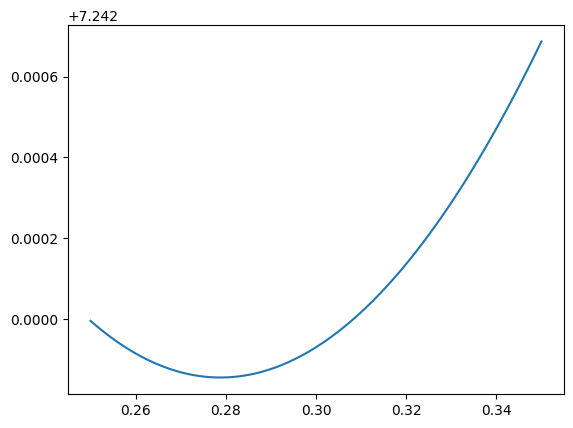

Min 7.241855236057016 at 0.27929292929292926


In [17]:
def single_pow(col, a):
    Y = y.copy().reshape(-1,1)
    x = X1.iloc[:,col].to_numpy().reshape(-1,1)
    mse=[]
    for p in a:
        X = x**p
        L = LinearRegression().fit(X,Y)
        mse+=[mean_squared_error(Y, L.predict(X))]
    plt.plot(a,mse)
    plt.show()
    return mse


a=np.linspace(0.25,0.35,100)
mse=single_pow(1,a)
print("Min",min(mse),"at",a[mse.index(min(mse))])

### Guess not.<br><br>
I did check if three powers would be better than two by tweaking fn find_best_pow. <br>
Not the best result (or time complexity). <br><br>

Two best powers it is

In [18]:
X_poly = X1.to_numpy()

def ready(X):
    X_poly=X.copy()[:,0].reshape(-1,1)
    X_poly1 = X.copy()

    for i in range(1,8):
        X_poly = np.hstack((X_poly,
                           (X_poly1[:,i]**best_pow[i][0]).reshape(-1,1),
                           (X_poly1[:,i]**best_pow[i][1]).reshape(-1,1)
                          ))
    return X_poly

X_poly=ready(X_poly)

X_0 = X_poly[:,1:][X_poly[:,0]==0]
X_1 = X_poly[:,1:][X_poly[:,0]==1]
X_2 = X_poly[:,1:][X_poly[:,0]==2]

y_0 = y[X_poly[:,0]==0]
y_1 = y[X_poly[:,0]==1]
y_2 = y[X_poly[:,0]==2]

### Engineered features are engineered.<br>
I train the regression with a little ridge for lower variance

In [19]:
#model0 = set_best_model(15, X_0, y_0, ridge=True)
#model1 = set_best_model(15, X_1, y_1, ridge=True)
#model2 = set_best_model(15, X_2, y_2, ridge=True)

model0 = Ridge(alpha=6.5e-6).fit(X_0, y_0)
print("Model 0, a score of", mean_squared_error(y_0, model0.predict(X_0)))
model1 = Ridge(alpha=6.5e-6).fit(X_1, y_1)
print("Model 1, a score of", mean_squared_error(y_1, model1.predict(X_1)))
model2 = Ridge(alpha=6.5e-6).fit(X_2, y_2)
print("Model 2, a score of", mean_squared_error(y_2, model2.predict(X_2)))

Model 0, a score of 5.632157583026819
Model 1, a score of 2.6099342503257073
Model 2, a score of 4.686366709398357


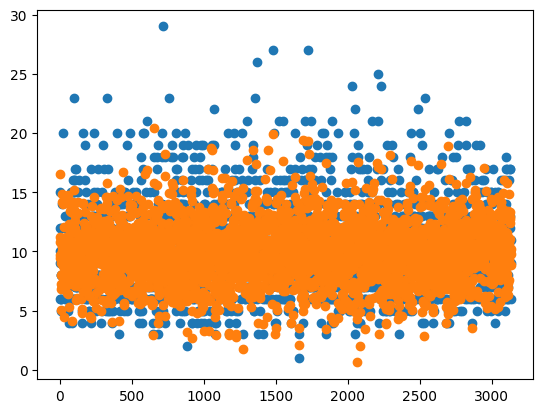

4.327956031354212

In [20]:
mother_fk = []
for i in range(len(X_poly)):
    if (X_poly[i,0]==0): mother_fk.extend( model0.predict( X_poly[i,1:].reshape(1,-1) ) )
    elif X_poly[i,0]==1: mother_fk.extend( model1.predict( X_poly[i,1:].reshape(1,-1) ) )
    elif X_poly[i,0]==2: mother_fk.extend( model2.predict( X_poly[i,1:].reshape(1,-1) ) )

mother_fk = np.array(mother_fk)
plt.scatter(range(len(X_poly)), y)
plt.scatter(range(len(X_poly)), mother_fk)
plt.show()
mean_squared_error(y, mother_fk)

### Can reduce 4.32 to 4.29 by adding random noise to best_pow but that would increase variance.

In [21]:
def F(epsilon): return mean_squared_error(y, [round(i) if abs(i-round(i))<epsilon else i for i in mother_fk])
a=np.linspace(0.03,0.04,99)
#for epsilon in a:
#    plt.scatter( epsilon, F(epsilon))
b =[F(epsilon) for epsilon in a]
print(f"Best epsilon is {a[b.index(min(b))]}, goshujin-sama~")
#plt.show()

epsilon = 0.038

Best epsilon is 0.03428571428571429, goshujin-sama~


### I round off to nearest int with tolerance $$\varepsilon = 0.038$$
regardless of what my program thinks is best.

# After done

In [22]:
test_data_poly = test_data.to_numpy()
test_data_poly = ready(test_data_poly)

### Any prediction less than zero is B.S. 
<br>I manhandle it

In [23]:
result = []
for i in range(len(test_data_poly)):
    if (test_data_poly[i,0]==0): result.extend( model0.predict( test_data_poly[i,1:].reshape(1,-1) ) )
    elif test_data_poly[i,0]==1: result.extend( model1.predict( test_data_poly[i,1:].reshape(1,-1) ) )
    elif test_data_poly[i,0]==2: result.extend( model2.predict( test_data_poly[i,1:].reshape(1,-1) ) )      
        
result = [round(i) if abs(i-round(i))<epsilon else i for i in result]   
result = np.array(result)

result[result<=0] = result[result>0].min()

result.min(), result.max()

(2.552039434576047, 19.52860809070499)

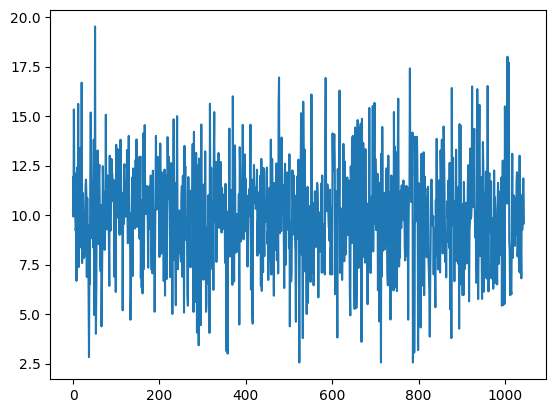

In [24]:
plt.plot(range(len(result)),result)
plt.show()

In [25]:
result = pd.DataFrame(zip(Index, result), columns = ['Index', 'Target'])
result

,Index,Target
0,866,11.922748
1,1483,9.921339
2,599,15.337300
3,1702,11.593332
4,670,12.120363
...,...,...
1040,532,9.254165
1041,3417,9.533206
1042,1505,11.834474
1043,2245,11.849774


In [26]:
pd.DataFrame(result).to_csv("submission1.csv", index=False) #(for making submission file)

In [27]:
result = pd.read_csv("submission1.csv")
result

,Index,Target
0,866,11.922748
1,1483,9.921339
2,599,15.337300
3,1702,11.593332
4,670,12.120363
...,...,...
1040,532,9.254165
1041,3417,9.533206
1042,1505,11.834474
1043,2245,11.849774
